# Single detector scanning

In [3]:
import os
import numpy as np
import healpy as hp
from beamconv import ScanStrategy, tools
import matplotlib.pyplot as plt
import time
import qpoint as qp
%matplotlib inline

In [4]:
def get_cls(fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'):
    cls = np.loadtxt(fname, unpack=True) # Cl in uK^2
    return cls[0], cls[1:]

In [5]:
nsamp=1000
lmax=700
fwhm=30.
ra0=-10 
dec0=-57.5
az_throw=50
scan_speed=2.8
rot_period=4.5*60*60
mmax=5
nside_spin=512

In [6]:
# Load up alm                                                                            
ell, cls = get_cls()
np.random.seed(39)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK  

In [7]:
# create Beam properties and pickle (this is just to test load_focal_plane)              
import tempfile
import shutil
import pickle
opj = os.path.join

blm_dir = os.path.abspath(opj('../tests/test_data/example_blms'))

po_file = opj(blm_dir, 'blm_hp_X1T1R1C8A_800_800.npy')
eg_file = opj(blm_dir, 'blm_hp_eg_X1T1R1C8A_800_800.npy')

#tmp_dir = tempfile.mkdtemp()

beam_file = 'beam_opts.pkl'
beam_opts = dict(az=0,
                 el=0,
                 polang=0.,
                 btype='Gaussian',
                 name='X1T1R1C8',
                 fwhm=32.2,
                 lmax=800,
                 mmax=800,
                 amplitude=1.,
                 po_file=po_file,
                 eg_file=eg_file,
                 deconv_q=True,  # blm are SH coeff from hp.alm2map                      
                 normalize=True)

In [14]:
print(beam_file)

with open(beam_file, 'wb') as handle:
    pickle.dump(beam_opts, handle, protocol=pickle.HIGHEST_PROTOCOL)

# init scan strategy and instrument                                                      
ss = ScanStrategy(nsamp/10., # mission duration in sec.                                  
                  sample_rate=10, # 10 Hz sample rate                                    
                  location='spole') # South pole instrument                              

ss.load_focal_plane('.', no_pairs=True)

# remove tmp dir and contents                                                            
#shutil.rmtree(tmp_dir)

# Generate timestreams with Gaussian beams and plot them                                 
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)

beam_opts.pkl
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000


Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000


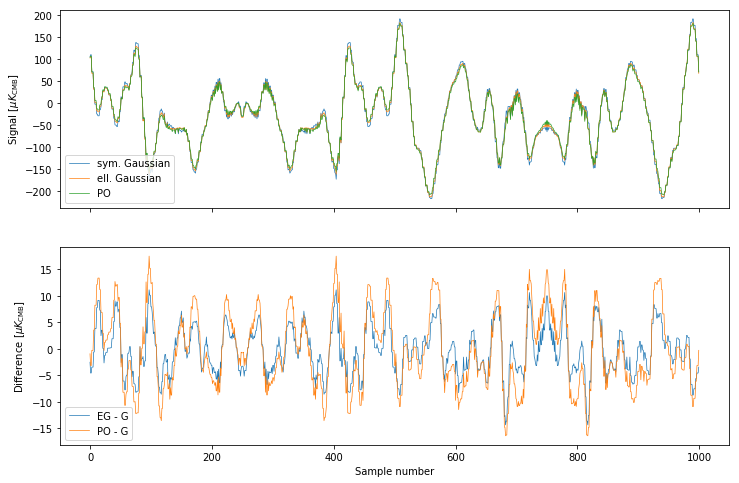

In [15]:
# init plot                                                                              
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

ax1.plot(ss.tod, label='sym. Gaussian', linewidth=0.7)
gauss_tod = ss.tod.copy()

# Generate timestreams with elliptical Gaussian beams and plot them                      
ss.beams[0][0].btype = 'EG'
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
ax1.plot(ss.tod, label='ell. Gaussian', linewidth=0.7)

eg_tod = ss.tod.copy()

# Generate timestreams with Physical Optics beams and plot them                          
ss.beams[0][0].btype = 'PO'
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)

ax1.plot(ss.tod, label='PO', linewidth=0.7)

po_tod = ss.tod.copy()

ax2.plot(eg_tod - gauss_tod, label='EG - G', linewidth=0.7)
ax2.plot(po_tod - gauss_tod, label='PO - G', linewidth=0.7)

ax1.legend()
ax2.legend()
ax1.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax2.set_ylabel(r'Difference [$\mu K_{\mathrm{CMB}}$]')
ax2.set_xlabel('Sample number')

In [13]:
po_tod

array([  1.03863375e+02,   1.06471140e+02,   1.06471171e+02,
         7.04102365e+01,   7.04102750e+01,   7.04103136e+01,
         3.52585751e+01,   3.52586159e+01,   5.45990982e+00,
         5.45995058e+00,   5.45999148e+00,  -1.30325179e+01,
        -1.30324802e+01,  -1.58894894e+01,  -1.58894630e+01,
        -1.58894365e+01,  -4.33574805e+00,  -4.33574378e+00,
        -1.76717621e+00,   1.41187408e+01,   1.41187186e+01,
         2.98053054e+01,   2.98052654e+01,   2.70888439e+01,
         3.68969828e+01,   3.68969408e+01,   3.58457089e+01,
         3.58456750e+01,   3.58456411e+01,   3.01460217e+01,
         3.01459953e+01,   2.14707535e+01,   2.14707301e+01,
         2.14707067e+01,   8.79797736e+00,   8.79795663e+00,
        -8.10397860e+00,  -8.10399359e+00,  -8.10400862e+00,
        -2.58155167e+01,  -2.58155242e+01,  -3.71485870e+01,
        -3.85571561e+01,  -3.85571566e+01,  -4.15765558e+01,
        -4.15765509e+01,  -3.10679323e+01,  -3.30200694e+01,
        -3.30200632e+01,